# Amazon Fine Food Reviews Analysis_RF and XGboost

***Shashi Sharma***, ss139529@gmail.com



Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import f1_score
from collections import Counter

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY TIME DESC LIMIT 80000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (80000, 10)


Id   ProductId          UserId    ProfileName  HelpfulnessNumerator  \
0    10  B00171APVA  A21BT40VZCCYT4  Carol A. Reed                     0   
1  1089  B004FD13RW    A1BPLP0BKERV           Paul                     0   
2  5703  B009WSNWC4   AMP7K1O84DH1T           ESTY                     0   

   HelpfulnessDenominator  Score        Time           Summary  \
0                       0      1  1351209600  Healthy Dog Food   
1                       0      1  1351209600    It is awesome.   
2                       0      1  1351209600         DELICIOUS   

                                                Text  
0  This is a very healthy dog food. Good for thei...  
1  My partner is very happy with the tea, and is ...  
2  Purchased this product at a local store in NY ...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(57496, 10)

In [10]:
#Sorting data according to Time in descending order
final=final.sort_values('Time', axis=0, ascending=True)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.87

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

Score=final['Score']

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(57496, 10)


1    47631
0     9865
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_1900 = final['Text'].values[1900]
print(sent_1900)
print("="*50)

I love being able to provide something healthy on the continental breakfast line, and Kashi cereal does that for me.  Individual bowls are more sanitary than a bin and a scoop.  The only low glycemic thing in the whole breakfast, except for bananas and milk.
I love these snacks!!!  I cannot find them in the stores around me so I order them here.  Very good for you and absolutely delicious.  Every kid and adult that I have let try them love them.  All the flavors are good too!  YUMMMMMMYYYY!!
While some people like to sip their fish sauce on the rocks, I prefer mine neat.  It's much more classical and brings out the sweet fermented flavor of the sauce.  I highly recommend this variety as it contains all of the fish pieces necessary to make a delicious sipping sauce.  The old bottles would have the eyes at the bottom, but they appear to have discontinued that, which is a real shame.  Still, this is the Johnny Walker Blue Label of fish sauces and it's so cheap.  Why not splurge and surpri

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_1900 = re.sub(r"http\S+", "", sent_1900)

print(sent_0)

I love being able to provide something healthy on the continental breakfast line, and Kashi cereal does that for me.  Individual bowls are more sanitary than a bin and a scoop.  The only low glycemic thing in the whole breakfast, except for bananas and milk.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1900, 'lxml')
text = soup.get_text()
print(text)

I love being able to provide something healthy on the continental breakfast line, and Kashi cereal does that for me.  Individual bowls are more sanitary than a bin and a scoop.  The only low glycemic thing in the whole breakfast, except for bananas and milk.
I love these snacks!!!  I cannot find them in the stores around me so I order them here.  Very good for you and absolutely delicious.  Every kid and adult that I have let try them love them.  All the flavors are good too!  YUMMMMMMYYYY!!
While some people like to sip their fish sauce on the rocks, I prefer mine neat.  It's much more classical and brings out the sweet fermented flavor of the sauce.  I highly recommend this variety as it contains all of the fish pieces necessary to make a delicious sipping sauce.  The old bottles would have the eyes at the bottom, but they appear to have discontinued that, which is a real shame.  Still, this is the Johnny Walker Blue Label of fish sauces and it's so cheap.  Why not splurge and surpri

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

While some people like to sip their fish sauce on the rocks, I prefer mine neat.  It is much more classical and brings out the sweet fermented flavor of the sauce.  I highly recommend this variety as it contains all of the fish pieces necessary to make a delicious sipping sauce.  The old bottles would have the eyes at the bottom, but they appear to have discontinued that, which is a real shame.  Still, this is the Johnny Walker Blue Label of fish sauces and it is so cheap.  Why not splurge and surprise your friends with a nice shot of this next time they come over for a party?


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I love being able to provide something healthy on the continental breakfast line, and Kashi cereal does that for me.  Individual bowls are more sanitary than a bin and a scoop.  The only low glycemic thing in the whole breakfast, except for bananas and milk.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

While some people like to sip their fish sauce on the rocks I prefer mine neat It is much more classical and brings out the sweet fermented flavor of the sauce I highly recommend this variety as it contains all of the fish pieces necessary to make a delicious sipping sauce The old bottles would have the eyes at the bottom but they appear to have discontinued that which is a real shame Still this is the Johnny Walker Blue Label of fish sauces and it is so cheap Why not splurge and surprise your friends with a nice shot of this next time they come over for a party 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 57496/57496 [00:16<00:00, 3562.96it/s]


In [24]:
preprocessed_reviews[1500]

'people like sip fish sauce rocks prefer mine neat much classical brings sweet fermented flavor sauce highly recommend variety contains fish pieces necessary make delicious sipping sauce old bottles would eyes bottom appear discontinued real shame still johnny walker blue label fish sauces cheap not splurge surprise friends nice shot next time come party'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

In [26]:
## Similartly you can do preprocessing for review summary also.
# printing some random summary
summ_0 = final['Summary'].values[0]
print(summ_0)
print("="*50)

summ_1000 = final['Summary'].values[1000]
print(summ_1000)

Kaashi Go Lean Individual Bowls
YUMMMM


In [27]:
## preprocessing the review summary to be use for feature engineering later. 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in (final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [28]:
preprocessed_summary[1500]

'great sipping fish sauce'

# [4] Featurization

In [29]:
# Splitting the preprocessed_reviews data:
Y = Score
X= preprocessed_reviews

In [30]:
np.shape(X)

(57496,)

In [31]:
print (57496*0.5)
print (57496*0.2)
print (57496*0.3)

28748.0
11499.2
17248.8


In [32]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X_train= X[0:28748]
X_cv= X[28748:40247]
X_test= X[40247:]
y_train= Y[0:28748]
y_cv= Y[28748:40247]
y_test= Y[40247:]

In [33]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_cv), np.shape(y_cv))
print(np.shape(X_test), np.shape(y_test))

(28748,) (28748,)
(11499,) (11499,)
(17249,) (17249,)


## [4.1] BAG OF WORDS

In [34]:
#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the number of unique words in X_train",X_train_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaallll', 'aaaahhhhhhhhhhh', 'aaah', 'aabout', 'aafco', 'aagreen', 'aah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train 32435
After vectorizations
(28748, 32435) (28748,)
(11499, 32435) (11499,)
(17249, 32435) (17249,)


## [4.2] Bi-Grams and n-Grams.

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(28748, 17259) (28748,)
(11499, 17259) (11499,)
(17249, 17259) (17249,)
The number of unique words in tf_idf_vect of X_train  17259


## [4.3] TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(28748, 17259) (28748,)
(11499, 17259) (11499,)
(17249, 17259) (17249,)
The number of unique words in tf_idf_vect of X_train  17259


## [4.4] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0
X_train_los=[] # List of sentence from X_Train
for sentance in X_train:
    X_train_los.append(sentance.split())

j=0
X_cv_los=[] # List of sentence from X_Train
for sentance in X_cv:
    X_cv_los.append(sentance.split())
    
k=0
X_test_los=[]
for sentance in X_test:
    X_test_los.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
#Using only X_Train to train the w2v_model (to avoid data leakage)
w2v_model=Word2Vec(X_train_los,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

print('='*50)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times in X_train",len(w2v_words))
print('='*50)
print("sample words ", w2v_words[0:50])

[('awesome', 0.8715746402740479), ('good', 0.7979403138160706), ('excellent', 0.7957174777984619), ('wonderful', 0.7833747863769531), ('perfect', 0.7455810308456421), ('fantastic', 0.7450010776519775), ('amazing', 0.7412582635879517), ('terrific', 0.7051928043365479), ('nice', 0.6848269701004028), ('fabulous', 0.6623497009277344)]
[('ever', 0.7625117897987366), ('best', 0.7424198985099792), ('unlink', 0.7191053032875061), ('closest', 0.7168477773666382), ('greatest', 0.6948931217193604), ('awful', 0.6896668076515198), ('ive', 0.6836143732070923), ('softest', 0.6796573400497437), ('disgusting', 0.6788276433944702), ('remember', 0.6524302363395691)]
number of words that occured minimum 5 times in X_train 10461
sample words  ['love', 'able', 'provide', 'something', 'healthy', 'breakfast', 'line', 'kashi', 'cereal', 'individual', 'bowls', 'bin', 'scoop', 'low', 'glycemic', 'thing', 'whole', 'except', 'bananas', 'milk', 'loved', 'gummy', 'bears', 'kid', 'nerds', 'like', 'not', 'dr', 'saw', 

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec for X_TRAIN
X_train_w2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train_los): # for each review/sentence in X_TRAIN
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_w2v.append(sent_vec)
print(len(X_train_w2v))
print(len(X_train_w2v[0]))
print('='*50)

# average Word2Vec for X_cv
X_cv_w2v=[];
for sent in tqdm(X_cv_los): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_w2v.append(sent_vec)
print(len(X_cv_w2v))
print(len(X_cv_w2v[0]))

# average Word2Vec for X_TEST
X_test_w2v=[];
for sent in tqdm(X_test_los): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_w2v.append(sent_vec)
print(len(X_test_w2v))
print(len(X_test_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 28748/28748 [00:28<00:00, 1002.74it/s]


28748
50


100%|███████████████████████████████████████████████████████████████████████████| 11499/11499 [00:11<00:00, 962.24it/s]


11499
50


100%|██████████████████████████████████████████████████████████████████████████| 17249/17249 [00:16<00:00, 1077.01it/s]


17249
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# Sentence = ["abc def pqr", "def def def abc", "pqr pqr def"]
#Using only X_Train to train the tfidfw2v_model (to avoid data leakage)
tfidf_model = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_matrix=tfidf_model.fit_transform(X_train)
tfidf_feat = tfidf_model.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(tfidf_model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec for X_TRAIN and X_test:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
a=0;
for sent in tqdm(X_train_los): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    a += 1

X_cv_tfidfw2v = [];
b=0;
for sent in tqdm(X_cv_los): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidfw2v.append(sent_vec)
    b += 1    
    
X_test_tfidfw2v = [];
c=0;
for sent in tqdm(X_test_los): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    c += 1

100%|███████████████████████████████████████████████████████████████████████████| 17249/17249 [01:48<00:00, 159.09it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [41]:
# Please write all the code with proper documentation
# Not necessary to standardize data while on Decition Tree.
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

In [42]:
# Hyper parameter Tuning using "Simple cross validation".
# Consider max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10], while perfomring hyper-parameter tunning,
# Because you train data doesn't contain 2^50 or 2^100 or 2^500 or 2^1000 datapoints.
train_auc = []
cv_auc = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and n_estimators are the hyperparameter
for i in depth:
        for j in k:
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf.fit(X_train_bow,y_train)
            train_bow_pred = clf.predict_proba(X_train_bow)[:,1]
            cv_bow_pred = clf.predict_proba(X_cv_bow)[:,1]
            train_auc.append(roc_auc_score(y_train,train_bow_pred))
            cv_auc.append(roc_auc_score(y_cv,cv_bow_pred))

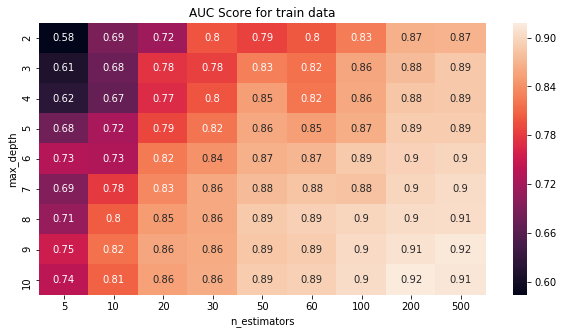

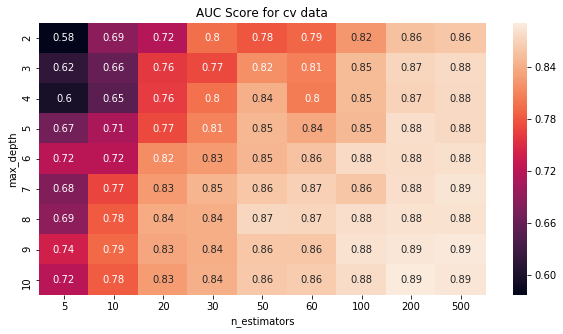

In [43]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data= np.array(train_auc).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

train_cv_data= np.array(cv_auc).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

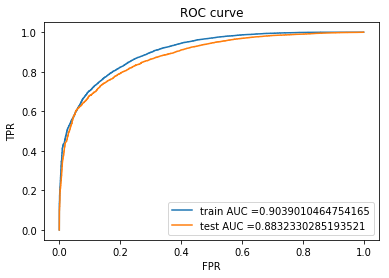

In [44]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF = RandomForestClassifier(criterion='gini', max_depth= 9, n_estimators= 200)
RF_CLF.fit(X_train_bow, y_train)

y_train_bow_pred = RF_CLF.predict_proba(X_train_bow)[:,1]   
y_test_bow_pred = RF_CLF.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_bow_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_bow_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

In [45]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

The maximum value of tpr*(1-fpr) 0.6606952997778915 for threshold 0.819
Train confusion matrix


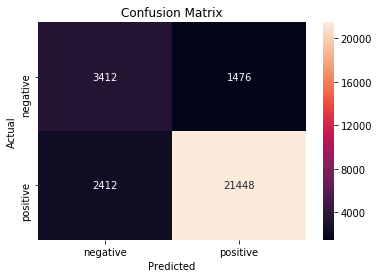

Test confusion matrix


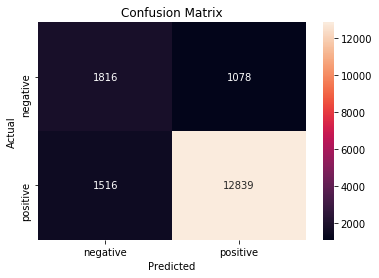

In [46]:
# Confusion matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
matrix_train= confusion_matrix(y_train, predict_with_best_t(y_train_bow_pred, best_t))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train= pd.DataFrame(matrix_train, columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train = confusion_matrix(y_test, predict_with_best_t(y_test_bow_pred, best_t))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train = pd.DataFrame(matrix_train,columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

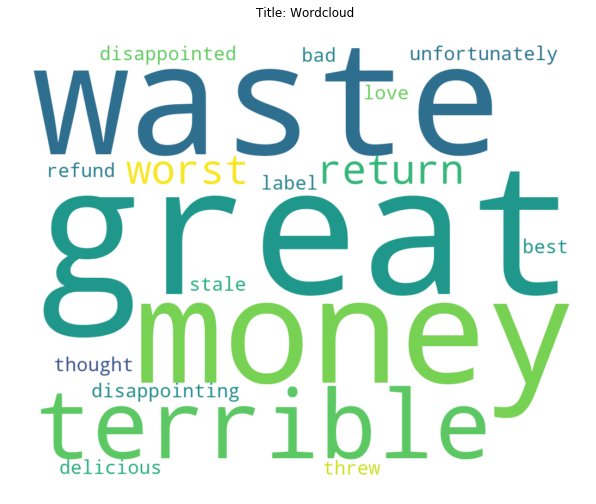

In [47]:
# Please write all the code with proper documentation
# Feature interaction come as an added inbuild benefit in Decition tree.
from wordcloud import WordCloud
Top20_feautures=""
feature_name_bow = count_vect.get_feature_names()
feature_impt=RF_CLF.feature_importances_
Top_features=np.argsort(feature_impt)[::-1]
for i in Top_features[0:20]:
    feauture= feature_name_bow[i]
    Top20_feautures+=feauture
    Top20_feautures+=" "
#print(Top20_feautures)    

#Getting the word cloud.
wordcloud = WordCloud(width = 1000, height = 800, background_color ='white', min_font_size = 10).generate(Top20_feautures) 
# plot the WordCloud image                        
plt.figure(figsize = (10, 8))
fig=plt.imshow(wordcloud, interpolation='bilinear', origin='upper')
plt.axis("off")
plt.title('Title: Wordcloud', y=1.05)
plt.show()

In [48]:
Top20_feautures

'great not would waste money terrible return worst disappointed thought unfortunately disappointing threw refund love stale best bad label delicious '

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [49]:
# Please write all the code with proper documentation
train_auc1 = []
cv_auc1 = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and n_estimators are the hyperparameter
for i in depth:
        for j in k:
            clf1 = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf1.fit(X_train_tfidf,y_train)
            train_tfidf_pred = clf1.predict_proba(X_train_tfidf)[:,1]
            cv_tfidf_pred = clf1.predict_proba(X_cv_tfidf)[:,1]
            train_auc1.append(roc_auc_score(y_train,train_tfidf_pred))
            cv_auc1.append(roc_auc_score(y_cv,cv_tfidf_pred))

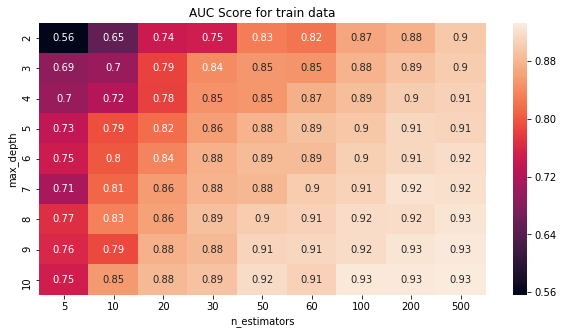

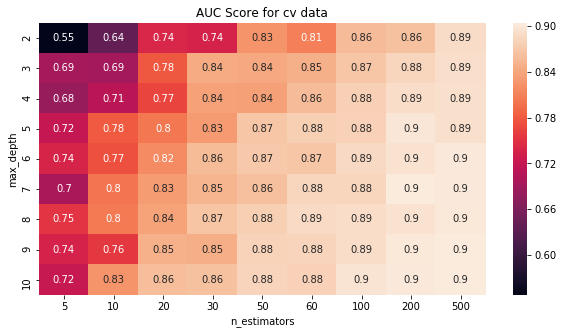

In [50]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data1= np.array(train_auc1).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data1, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

train_cv_data1= np.array(cv_auc1).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data1, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

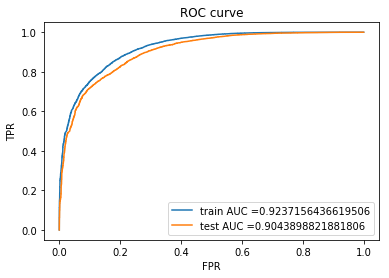

In [51]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF1 = RandomForestClassifier(criterion='gini',max_depth= 8, n_estimators= 200)
RF_CLF1.fit(X_train_tfidf, y_train)

y_train_tfidf_pred = RF_CLF1.predict_proba(X_train_tfidf)[:,1]   
y_test_tfidf_pred = RF_CLF1.predict_proba(X_test_tfidf)[:,1]

train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, y_train_tfidf_pred)
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, y_test_tfidf_pred)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.7005559915107632 for threshold 0.809
Train confusion matrix


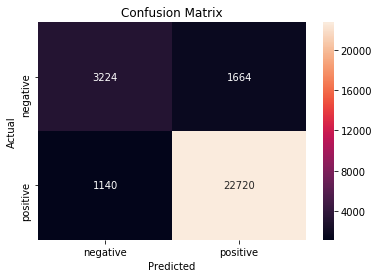

Test confusion matrix


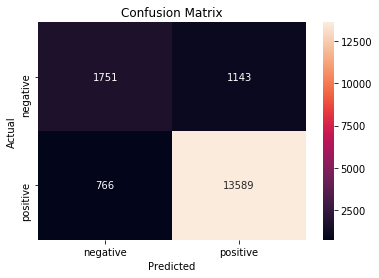

In [52]:
# Confusion matrix
best_t1 = find_best_threshold(thresholds1, train_fpr1, train_tpr1)
print("Train confusion matrix")
matrix_train1= confusion_matrix(y_train, predict_with_best_t(y_train_tfidf_pred, best_t1))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1= pd.DataFrame(matrix_train1, columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train1 = confusion_matrix(y_test, predict_with_best_t(y_test_tfidf_pred, best_t1))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1 = pd.DataFrame(matrix_train1,columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

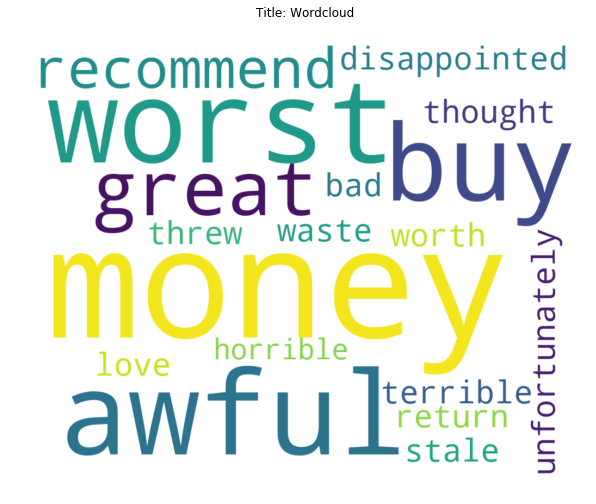

In [53]:
# Please write all the code with proper documentation
# Feature interaction come as an added inbuild benefit in Decition tree.
from wordcloud import WordCloud
Top20_feautures1=""
feature_name_tfidf = tf_idf_vect.get_feature_names()
feature_impt1=RF_CLF1.feature_importances_
Top_features1=np.argsort(feature_impt1)[::-1]
for i in Top_features1[0:20]:
    feauture1= feature_name_tfidf[i]
    Top20_feautures1+=feauture1
    Top20_feautures1+="   "
#print(Top20_feautures)    

#Getting the word cloud.
wordcloud1 = WordCloud(width = 1000, height = 800, background_color ='white', min_font_size = 10).generate(Top20_feautures1) 
# plot the WordCloud image                        
plt.figure(figsize = (10, 8))
fig=plt.imshow(wordcloud1, interpolation='bilinear', origin='upper')
plt.axis("off")
plt.title('Title: Wordcloud', y=1.05)
plt.show()

In [54]:
Top20_feautures1

'not   worst   awful   not buy   great   money   not recommend   disappointed   would not   waste money   love   bad   unfortunately   not worth   thought   terrible   stale   threw   return   horrible   '

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [55]:
# Please write all the code with proper documentation
train_auc2 = []
cv_auc2 = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and n_estimators are the hyperparameter
for i in depth:
        for j in k:
            clf2 = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf2.fit(X_train_w2v,y_train)
            train_w2v_pred = clf2.predict_proba(X_train_w2v)[:,1]
            cv_w2v_pred = clf2.predict_proba(X_cv_w2v)[:,1]
            train_auc2.append(roc_auc_score(y_train,train_w2v_pred))
            cv_auc2.append(roc_auc_score(y_cv,cv_w2v_pred))

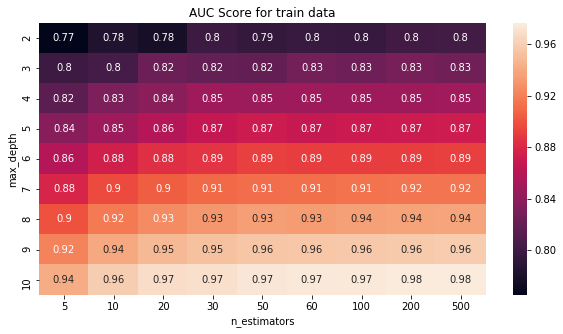

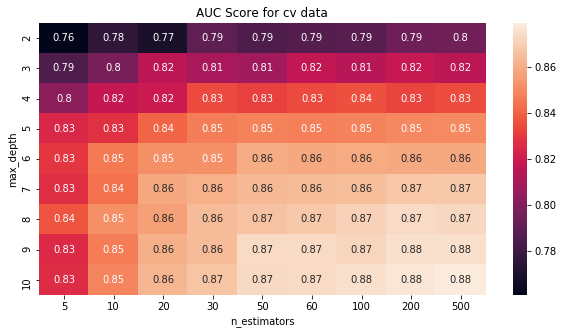

In [56]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data2= np.array(train_auc2).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data2, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

cv_auc_data2= np.array(cv_auc2).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(cv_auc_data2, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

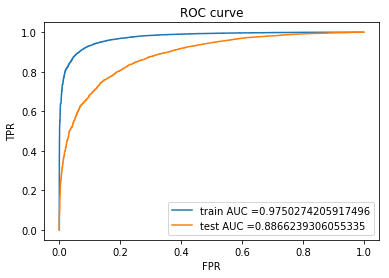

In [57]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF2 = RandomForestClassifier(criterion='gini',max_depth= 10, n_estimators= 100)
RF_CLF2.fit(X_train_w2v, y_train)

y_train_w2v_pred = RF_CLF2.predict_proba(X_train_w2v)[:,1]   
y_test_w2v_pred = RF_CLF2.predict_proba(X_test_w2v)[:,1]

train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, y_train_w2v_pred)
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, y_test_w2v_pred)

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.8441260428056188 for threshold 0.842
Train confusion matrix


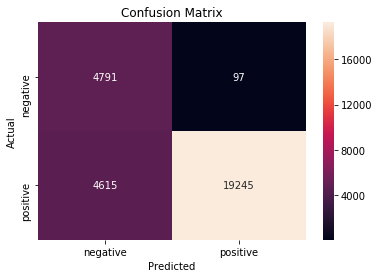

Test confusion matrix


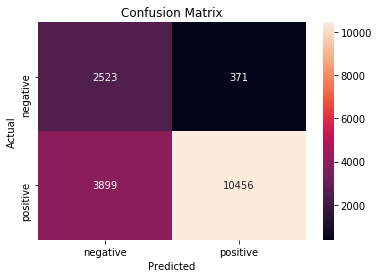

In [58]:
# Confusion matrix
best_t2 = find_best_threshold(thresholds2, train_fpr2, train_tpr2)
print("Train confusion matrix")
matrix_train2= confusion_matrix(y_train, predict_with_best_t(y_train_w2v_pred, best_t2))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2= pd.DataFrame(matrix_train2, columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train2 = confusion_matrix(y_test, predict_with_best_t(y_test_w2v_pred, best_t2))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2 = pd.DataFrame(matrix_train2,columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [59]:
# Please write all the code with proper documentation
train_auc3 = []
cv_auc3 = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and sample_split are the hyperparameter
for i in depth:
        for j in k:
            clf3 = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf3.fit(X_train_tfidfw2v,y_train)
            train_tfidfw2v_pred = clf3.predict_proba(X_train_tfidfw2v)[:,1]
            cv_tfidfw2v_pred = clf3.predict_proba(X_cv_tfidfw2v)[:,1]
            train_auc3.append(roc_auc_score(y_train,train_tfidfw2v_pred))
            cv_auc3.append(roc_auc_score(y_cv,cv_tfidfw2v_pred))

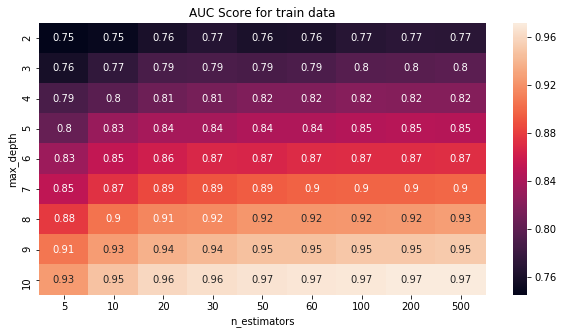

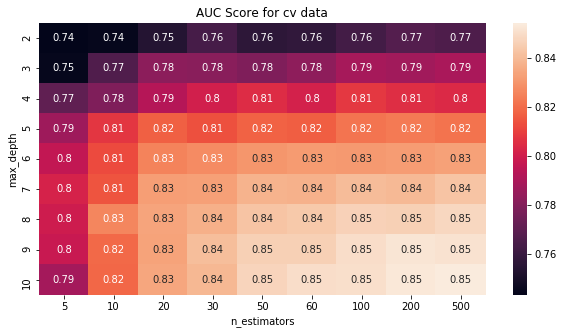

In [60]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data3= np.array(train_auc3).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data3, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

train_cv_data3= np.array(cv_auc3).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data3, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

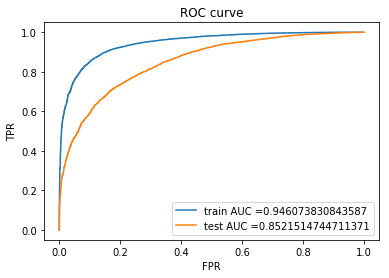

In [63]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF3 = RandomForestClassifier(criterion='gini',max_depth= 9, n_estimators= 50)
RF_CLF3.fit(X_train_tfidfw2v, y_train)

y_train_tfidfw2v_pred = RF_CLF3.predict_proba(X_train_tfidfw2v)[:,1]   
y_test_tfidfw2v_pred = RF_CLF3.predict_proba(X_test_tfidfw2v)[:,1]

train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, y_train_tfidfw2v_pred)
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, y_test_tfidfw2v_pred)

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.7686872018718026 for threshold 0.826
Train confusion matrix


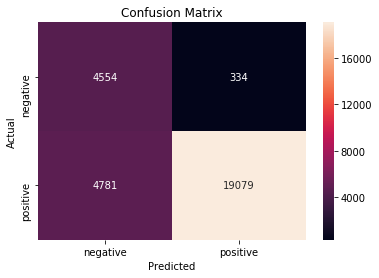

Test confusion matrix


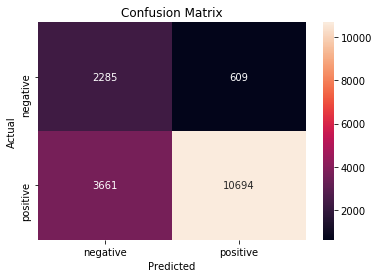

In [64]:
# Confusion matrix
best_t3 = find_best_threshold(thresholds3, train_fpr3, train_tpr3)
print("Train confusion matrix")
matrix_train3= confusion_matrix(y_train, predict_with_best_t(y_train_tfidfw2v_pred, best_t3))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3= pd.DataFrame(matrix_train3, columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train3 = confusion_matrix(y_test, predict_with_best_t(y_test_tfidfw2v_pred, best_t3))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3 = pd.DataFrame(matrix_train3,columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [68]:
# Please write all the code with proper documentation
from xgboost import XGBClassifier
train_auc4 = []
cv_auc4 = []
k = [5,10,20,30,50,60,100,200] 
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100,1000]
# Here learning_rate and n_estimators are the hyperparameter
for i in learning_rate:
        for j in k:
            clf4 = XGBClassifier(max_depth=3, learning_rate=i, n_estimators=j, booster='gbtree')
            clf4.fit(X_train_bow, y_train)
            train_bow_pred1= clf4.predict_proba(X_train_bow)[:,1]
            cv_bow_pred1= clf4.predict_proba(X_cv_bow)[:,1]
            train_auc4.append(roc_auc_score(y_train,train_bow_pred1))
            cv_auc4.append(roc_auc_score(y_cv,cv_bow_pred1))

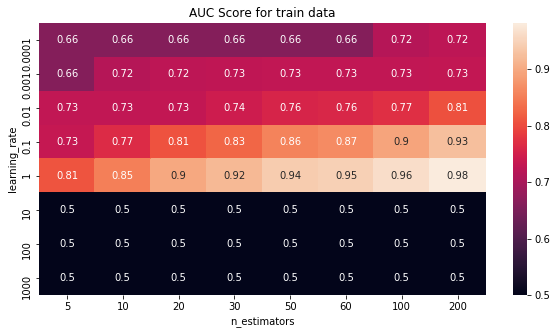

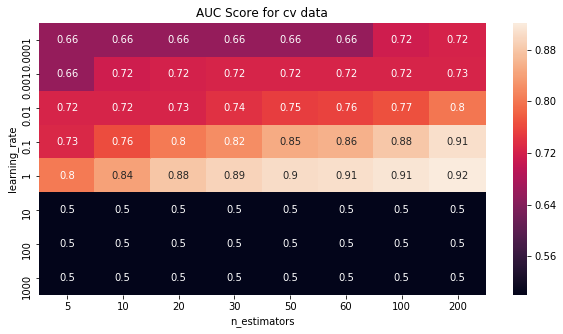

In [72]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data4= np.array(train_auc4).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data4, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

print('='*50)
print('='*50)

train_cv_data4= np.array(cv_auc4).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data4, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

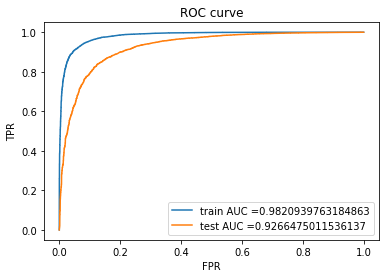

In [73]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF4 = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=200, booster='gbtree')
RF_CLF4.fit(X_train_bow, y_train)


y_train_bow_pred1 = RF_CLF4.predict_proba(X_train_bow)[:,1]   
y_test_bow_pred1 = RF_CLF4.predict_proba(X_test_bow)[:,1]

train_fpr4, train_tpr4, thresholds4 = roc_curve(y_train, y_train_bow_pred1)
test_fpr4, test_tpr4, thresholds4 = roc_curve(y_test, y_test_bow_pred1)

plt.plot(train_fpr4, train_tpr4, label="train AUC ="+str(auc(train_fpr4, train_tpr4)))
plt.plot(test_fpr4, test_tpr4, label="test AUC ="+str(auc(test_fpr4, test_tpr4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.867642569928511 for threshold 0.235
Train confusion matrix


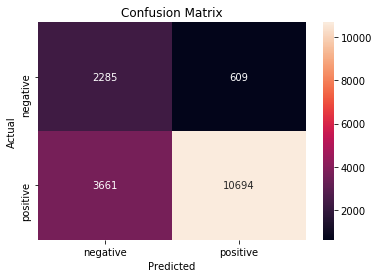

Test confusion matrix


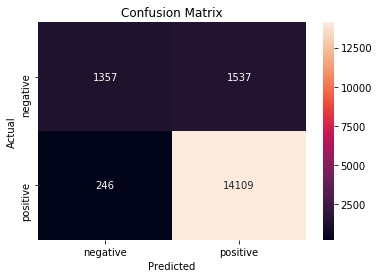

In [74]:
# Confusion matrix
best_t4 = find_best_threshold(thresholds4, train_fpr4, train_tpr4)
print("Train confusion matrix")
matrix_train4= confusion_matrix(y_train, predict_with_best_t(y_train_bow_pred1, best_t4))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3= pd.DataFrame(matrix_train3, columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train4 = confusion_matrix(y_test, predict_with_best_t(y_test_bow_pred1, best_t4))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train4 = pd.DataFrame(matrix_train4,columns,index)
sns.heatmap(df_matrix_train4, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [85]:
# Please write all the code with proper documentation
train_auc5 = []
cv_auc5 = []
k = [5,10,20,30,50,60,100,200] 
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100,1000]
# Here learning_rate and n_estimators are the hyperparameter
for i in learning_rate:
        for j in k:
            clf5 = XGBClassifier(max_depth=3, learning_rate=i, n_estimators=j, booster='gbtree')
            clf5.fit(X_train_tfidf, y_train)
            train_tfidf_pred1= clf5.predict_proba(X_train_tfidf)[:,1]
            cv_tfidf_pred1= clf5.predict_proba(X_cv_tfidf)[:,1]
            train_auc5.append(roc_auc_score(y_train,train_tfidf_pred1))
            cv_auc5.append(roc_auc_score(y_cv,cv_tfidf_pred1))

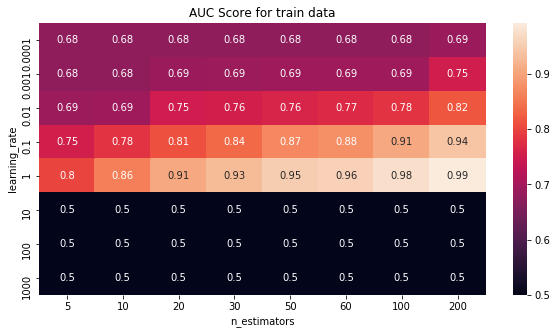

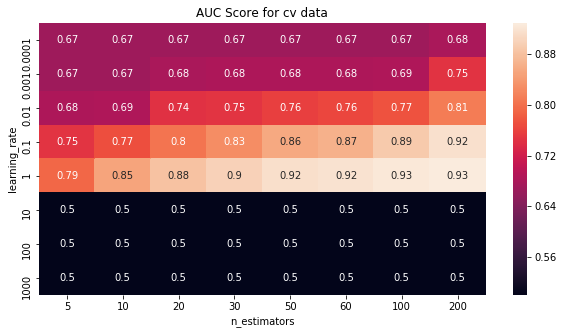

In [86]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data5= np.array(train_auc5).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data5, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

print('='*50)
print('='*50)

cv_auc_data5= np.array(cv_auc5).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cv_auc_data5, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

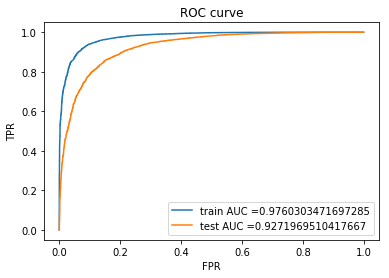

In [89]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF5 = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=100, booster='gbtree')
RF_CLF5.fit(X_train_tfidf, y_train)


y_train_tfidf_pred1 = RF_CLF5.predict_proba(X_train_tfidf)[:,1]   
y_test_tfidf_pred1 = RF_CLF5.predict_proba(X_test_tfidf)[:,1]

train_fpr5, train_tpr5, thresholds5 = roc_curve(y_train, y_train_tfidf_pred1)
test_fpr5, test_tpr5, thresholds5 = roc_curve(y_test, y_test_tfidf_pred1)

plt.plot(train_fpr5, train_tpr5, label="train AUC ="+str(auc(train_fpr5, train_tpr5)))
plt.plot(test_fpr5, test_tpr5, label="test AUC ="+str(auc(test_fpr5, test_tpr5)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.8491810520452778 for threshold 0.021
Train confusion matrix


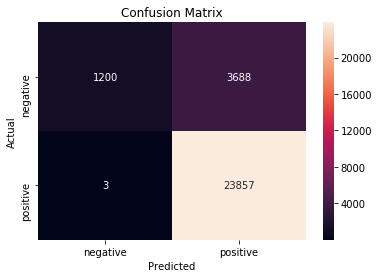

Test confusion matrix


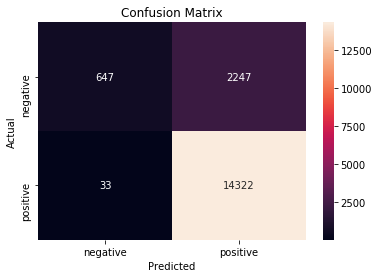

In [90]:
# Confusion matrix
best_t5 = find_best_threshold(thresholds5, train_fpr5, train_tpr5)
print("Train confusion matrix")
matrix_train5= confusion_matrix(y_train, predict_with_best_t(y_train_tfidf_pred1, best_t5))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train5= pd.DataFrame(matrix_train5, columns,index)
sns.heatmap(df_matrix_train5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train5 = confusion_matrix(y_test, predict_with_best_t(y_test_tfidf_pred1, best_t5))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train5 = pd.DataFrame(matrix_train5,columns,index)
sns.heatmap(df_matrix_train5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [80]:
X_train_w2v = np.array(X_train_w2v)

In [91]:
# Please write all the code with proper documentation
train_auc6 = []
cv_auc6 = []
k = [5,10,20,30,50,60,100,200] 
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100,1000]
# Here learning_rate and n_estimators are the hyperparameter
for i in learning_rate:
        for j in k:
            clf6 = XGBClassifier(max_depth=3, learning_rate=i, n_estimators=j, booster='gbtree')
            clf6.fit(X_train_w2v, y_train)
            train_w2v_pred1= clf6.predict_proba(X_train_w2v)[:,1]
            cv_w2v_pred1= clf6.predict_proba(X_cv_w2v)[:,1]
            train_auc6.append(roc_auc_score(y_train,train_w2v_pred1))
            cv_auc6.append(roc_auc_score(y_cv,cv_w2v_pred1))

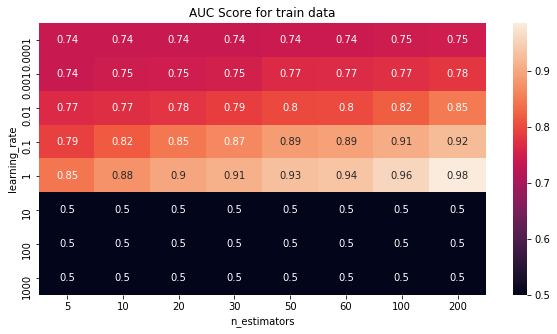

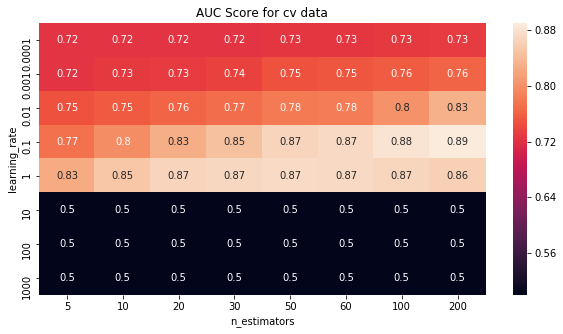

In [92]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data6= np.array(train_auc6).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data6, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

print('='*50)
print('='*50)

cv_auc_data6= np.array(cv_auc6).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(cv_auc_data6, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

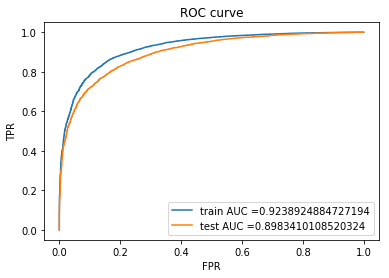

In [93]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF6 = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, booster='gbtree')
RF_CLF6.fit(X_train_w2v, y_train)


y_train_w2v_pred1 = RF_CLF6.predict_proba(X_train_w2v)[:,1]   
y_test_w2v_pred1 = RF_CLF6.predict_proba(X_test_w2v)[:,1]

train_fpr6, train_tpr6, thresholds6 = roc_curve(y_train, y_train_w2v_pred1)
test_fpr6, test_tpr6, thresholds6 = roc_curve(y_test, y_test_w2v_pred1)

plt.plot(train_fpr6, train_tpr6, label="train AUC ="+str(auc(train_fpr6, train_tpr6)))
plt.plot(test_fpr6, test_tpr6, label="test AUC ="+str(auc(test_fpr6, test_tpr6)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.7196380310403157 for threshold 0.682
Train confusion matrix


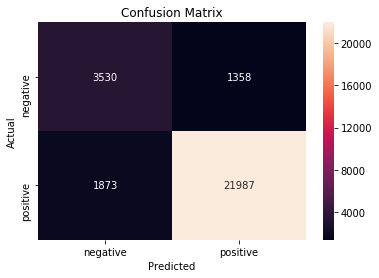

Test confusion matrix


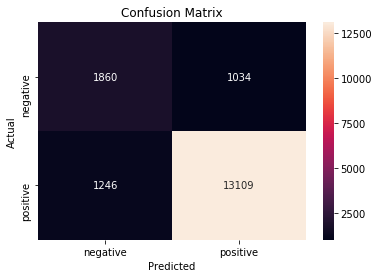

In [94]:
# Confusion matrix
best_t6 = find_best_threshold(thresholds6, train_fpr6, train_tpr6)
print("Train confusion matrix")
matrix_train6= confusion_matrix(y_train, predict_with_best_t(y_train_w2v_pred1, best_t6))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train6= pd.DataFrame(matrix_train6, columns,index)
sns.heatmap(df_matrix_train6, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train6 = confusion_matrix(y_test, predict_with_best_t(y_test_w2v_pred1, best_t6))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train6 = pd.DataFrame(matrix_train6,columns,index)
sns.heatmap(df_matrix_train6, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [95]:
X_train_tfidfw2v = np.array(X_train_tfidfw2v)

In [96]:
# Please write all the code with proper documentation
train_auc7 = []
cv_auc7 = []
k = [5,10,20,30,50,60,100,200] 
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100,1000]
# Here learning_rate and n_estimators are the hyperparameter
for i in learning_rate:
        for j in k:
            clf7 = XGBClassifier(max_depth=3, learning_rate=i, n_estimators=j, booster='gbtree')
            clf7.fit(X_train_tfidfw2v, y_train)
            train_tfidfw2v_pred1= clf7.predict_proba(X_train_tfidfw2v)[:,1]
            cv_tfidfw2v_pred1= clf7.predict_proba(X_cv_tfidfw2v)[:,1]
            train_auc7.append(roc_auc_score(y_train,train_tfidfw2v_pred1))
            cv_auc7.append(roc_auc_score(y_cv,cv_tfidfw2v_pred1))

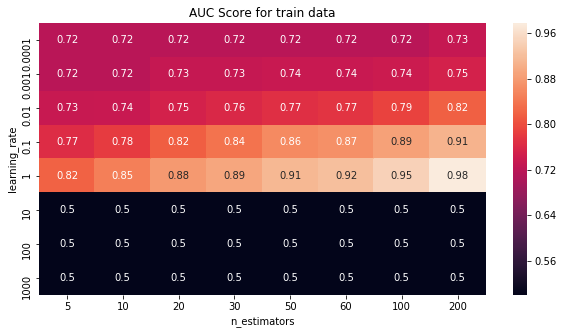

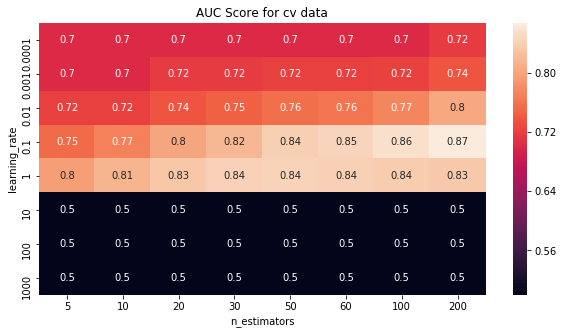

In [97]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data7= np.array(train_auc7).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data7, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

print('='*50)
print('='*50)

train_cv_data7= np.array(cv_auc7).reshape(8,8)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data7, xticklabels=k, yticklabels=learning_rate, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

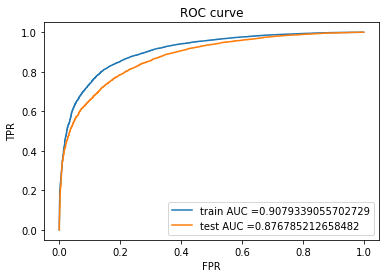

In [98]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF7 = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, booster='gbtree')
RF_CLF7.fit(X_train_tfidfw2v, y_train)


y_train_tfidfw2v_pred1 = RF_CLF7.predict_proba(X_train_tfidfw2v)[:,1]   
y_test_tfidfw2v_pred1 = RF_CLF7.predict_proba(X_test_tfidfw2v)[:,1]

train_fpr7, train_tpr7, thresholds7 = roc_curve(y_train, y_train_tfidfw2v_pred1)
test_fpr7, test_tpr7, thresholds7 = roc_curve(y_test, y_test_tfidfw2v_pred1)

plt.plot(train_fpr7, train_tpr7, label="train AUC ="+str(auc(train_fpr7, train_tpr7)))
plt.plot(test_fpr7, test_tpr7, label="test AUC ="+str(auc(test_fpr7, test_tpr7)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.6920180869584305 for threshold 0.761
Train confusion matrix


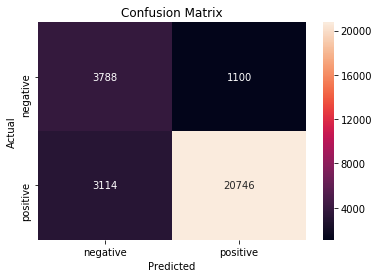

Test confusion matrix


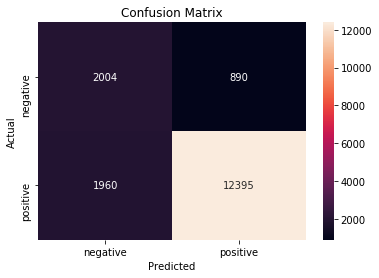

In [99]:
# Confusion matrix
best_t7 = find_best_threshold(thresholds7, train_fpr7, train_tpr7)
print("Train confusion matrix")
matrix_train7= confusion_matrix(y_train, predict_with_best_t(y_train_tfidfw2v_pred1, best_t7))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train7= pd.DataFrame(matrix_train7, columns,index)
sns.heatmap(df_matrix_train7, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train7 = confusion_matrix(y_test, predict_with_best_t(y_test_tfidfw2v_pred1, best_t7))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train7 = pd.DataFrame(matrix_train7,columns,index)
sns.heatmap(df_matrix_train7, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## [6] Feature engineering:

In [100]:
# Finding the lenght of the review:
Review_len = [len(sentence.split()) for sentence in preprocessed_reviews]

In [101]:
Review_len[1500]

54

In [102]:
preprocessed_reviews[1500]

'people like sip fish sauce rocks prefer mine neat much classical brings sweet fermented flavor sauce highly recommend variety contains fish pieces necessary make delicious sipping sauce old bottles would eyes bottom appear discontinued real shame still johnny walker blue label fish sauces cheap not splurge surprise friends nice shot next time come party'

In [103]:
#Adding review length and summary to preprocessed_review as the part of Feature engineering:
preprocessed_reviews1= []
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]+' '+str(Review_len[i])
    preprocessed_reviews1.append(preprocessed_reviews[i])

In [104]:
preprocessed_reviews1[1500]

'people like sip fish sauce rocks prefer mine neat much classical brings sweet fermented flavor sauce highly recommend variety contains fish pieces necessary make delicious sipping sauce old bottles would eyes bottom appear discontinued real shame still johnny walker blue label fish sauces cheap not splurge surprise friends nice shot next time come party great sipping fish sauce 54'

In [105]:
X1= preprocessed_reviews1
Y1 = Score

In [108]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X1_train= X1[0:28748]
X1_cv= X1[28748:40247]
X1_test= X1[40247:]
y1_train= Y1[0:28748]
y1_cv= Y1[28748:40247]
y1_test= Y1[40247:]

### [6.1]  FE: Applying Random Forest on BOW,<font color='red'> SET 1</font>

In [109]:
# Please write all the code with proper documentation
#BoW
count_vect1 = CountVectorizer()
count_vect1.fit(X1_train) # fit has to happen only on train data

X_train_fe_bow = count_vect1.transform(X1_train)
X_cv_fe_bow = count_vect1.transform(X1_cv)
X_test_fe_bow = count_vect1.transform(X1_test)

print("the type of count vectorizer ",type(X_train_fe_bow))
print("the number of unique words in X_train_fe",X_train_fe_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_fe_bow.shape, y1_train.shape)
print(X_cv_fe_bow.shape, y1_cv.shape)
print(X_test_fe_bow.shape, y1_test.shape)
print("="*50)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train_fe 33885
After vectorizations
(28748, 33885) (28748,)
(11499, 33885) (11499,)
(17249, 33885) (17249,)


In [112]:
train_auc8 = []
cv_auc8 = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and n_estimators are the hyperparameter
for i in depth:
        for j in k:
            clf8 = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf8.fit(X_train_fe_bow,y1_train)
            train_fe_bow_pred = clf8.predict_proba(X_train_fe_bow)[:,1]
            cv_fe_bow_pred = clf8.predict_proba(X_cv_fe_bow)[:,1]
            train_auc8.append(roc_auc_score(y1_train,train_fe_bow_pred))
            cv_auc8.append(roc_auc_score(y1_cv,cv_fe_bow_pred))

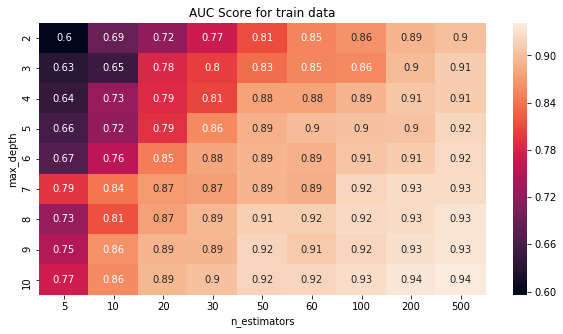

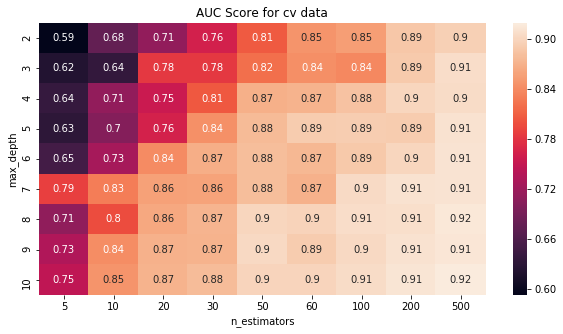

In [113]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data8= np.array(train_auc8).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data8, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

train_cv_data8= np.array(cv_auc8).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data8, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

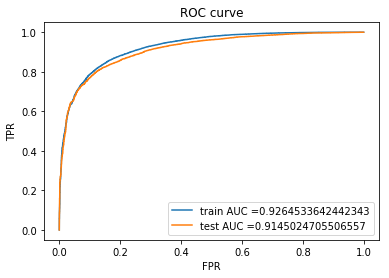

In [114]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF8 = RandomForestClassifier(criterion='gini', max_depth= 8, n_estimators= 100)
RF_CLF8.fit(X_train_fe_bow, y1_train)

y_train_fe_bow_pred = RF_CLF8.predict_proba(X_train_fe_bow)[:,1]   
y_test_fe_bow_pred = RF_CLF8.predict_proba(X_test_fe_bow)[:,1]

train_fpr8, train_tpr8, thresholds8 = roc_curve(y1_train, y_train_fe_bow_pred)
test_fpr8, test_tpr8, thresholds8 = roc_curve(y1_test, y_test_fe_bow_pred)

plt.plot(train_fpr8, train_tpr8, label="train AUC ="+str(auc(train_fpr8, train_tpr8)))
plt.plot(test_fpr8, test_tpr8, label="test AUC ="+str(auc(test_fpr8, test_tpr8)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.717959981712746 for threshold 0.809
Train confusion matrix


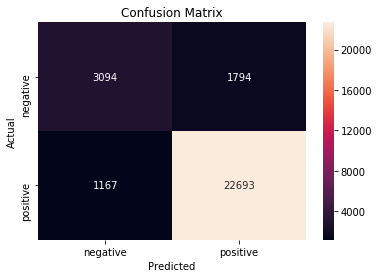

Test confusion matrix


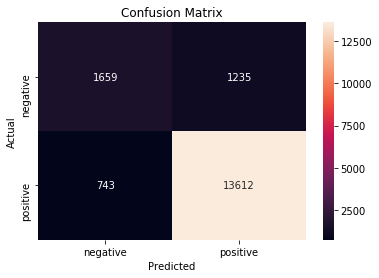

In [115]:
# Confusion matrix
best_t8 = find_best_threshold(thresholds8, train_fpr8, train_tpr8)
print("Train confusion matrix")
matrix_train8= confusion_matrix(y1_train, predict_with_best_t(y_train_fe_bow_pred, best_t8))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train8= pd.DataFrame(matrix_train8, columns,index)
sns.heatmap(df_matrix_train8, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train8 = confusion_matrix(y1_test, predict_with_best_t(y_test_fe_bow_pred, best_t8))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train8 = pd.DataFrame(matrix_train8,columns,index)
sns.heatmap(df_matrix_train8, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [6.1]  FE: Applying Random Forest on TFIDF,<font color='red'> SET 2</font>

In [116]:
# Please write all the code with proper documentation
#tfidf
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect1.fit(X1_train)
print('='*50)

X_train_fe_tfidf = tf_idf_vect1.transform(X1_train)
X_cv_fe_tfidf = tf_idf_vect1.transform(X1_cv)
X_test_fe_tfidf = tf_idf_vect1.transform(X1_test)
print("the type of tf_idf_vect1",type(X_train_fe_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_fe_tfidf.shape, y1_train.shape)
print(X_cv_fe_tfidf.shape, y1_cv.shape)
print(X_test_fe_tfidf.shape, y1_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect1 of X_train_fe ", X_train_fe_tfidf.shape[1])

the type of tf_idf_vect1 <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(28748, 18743) (28748,)
(11499, 18743) (11499,)
(17249, 18743) (17249,)
The number of unique words in tf_idf_vect1 of X_train_fe  18743


In [117]:
train_auc9 = []
cv_auc9 = []
k = [5,10,20,30,50,60,100,200,500] 
depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Here depth and n_estimators are the hyperparameter
for i in depth:
        for j in k:
            clf9 = RandomForestClassifier(n_estimators=j, max_depth=i, max_features='sqrt')
            clf9.fit(X_train_fe_tfidf,y1_train)
            train_fe_tfidf_pred = clf9.predict_proba(X_train_fe_tfidf)[:,1]
            cv_fe_tfidf_pred = clf9.predict_proba(X_cv_fe_tfidf)[:,1]
            train_auc9.append(roc_auc_score(y1_train,train_fe_tfidf_pred))
            cv_auc9.append(roc_auc_score(y1_cv,cv_fe_tfidf_pred))

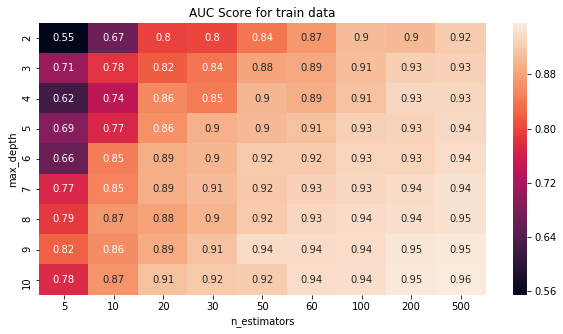

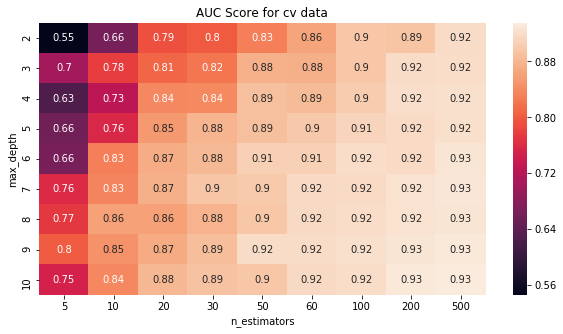

In [118]:
# Performance of model using sns.heatmap
# Representing the Auc score
train_auc_data9= np.array(train_auc9).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_auc_data9, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for train data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

print('='*50)
print('='*50)

train_cv_data9= np.array(cv_auc9).reshape(9,9)
plt.figure(figsize=(10,5))
sns.heatmap(train_cv_data9, xticklabels=k, yticklabels=depth, annot=True)
plt.title("AUC Score for cv data") 
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

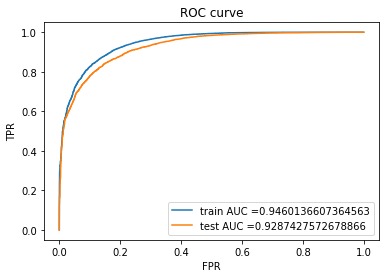

In [119]:
#training our model with the best hyperparameters, and find the AUC on test data and plot the ROC curve on both train and test.
RF_CLF9 = RandomForestClassifier(criterion='gini', max_depth= 9, n_estimators= 200)
RF_CLF9.fit(X_train_fe_tfidf, y1_train)

y_train_fe_tfidf_pred = RF_CLF9.predict_proba(X_train_fe_tfidf)[:,1]   
y_test_fe_tfidf_pred = RF_CLF9.predict_proba(X_test_fe_tfidf)[:,1]

train_fpr9, train_tpr9, thresholds9 = roc_curve(y1_train, y_train_fe_tfidf_pred)
test_fpr9, test_tpr9, thresholds9 = roc_curve(y1_test, y_test_fe_tfidf_pred)

plt.plot(train_fpr9, train_tpr9, label="train AUC ="+str(auc(train_fpr9, train_tpr9)))
plt.plot(test_fpr9, test_tpr9, label="test AUC ="+str(auc(test_fpr9, test_tpr9)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

The maximum value of tpr*(1-fpr) 0.7512805193415492 for threshold 0.803
Train confusion matrix


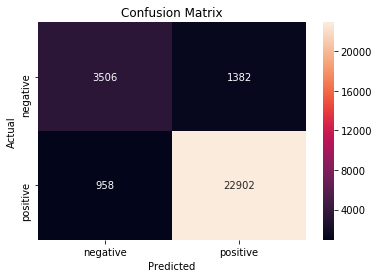

Test confusion matrix


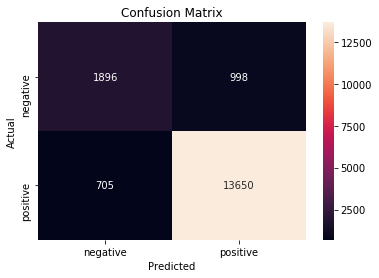

In [120]:
# Confusion matrix
best_t9 = find_best_threshold(thresholds9, train_fpr9, train_tpr9)
print("Train confusion matrix")
matrix_train9= confusion_matrix(y1_train, predict_with_best_t(y_train_fe_tfidf_pred, best_t9))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train9= pd.DataFrame(matrix_train9, columns,index)
sns.heatmap(df_matrix_train9, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_train9 = confusion_matrix(y1_test, predict_with_best_t(y_test_fe_tfidf_pred, best_t9))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train9 = pd.DataFrame(matrix_train9,columns,index)
sns.heatmap(df_matrix_train9, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## [ 7] Summary:

In [121]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "FE Data", "Hyperparameters", "Test AUC"]
x.add_row(["Random Forest","BOW", "No", "max_depth=9, k=200", 0.8832])
x.add_row(["Random Forest","TFIDF","No",  "max_depth=8, k=200", 0.9043])
x.add_row(["Random Forest","Avg W2V","No",  "max_depth=10, k=100", 0.8866])
x.add_row(["Random Forest","TFIDF Avg W2v","No", "max_depth=9, k=50", 0.8521])
x.add_row(["XGBOOST","BOW","No", "Learning_rate=1, k=200", 0.9266])
x.add_row(["XGBOOST","TFIDF","No","Learning_rate=1, k=100", 0.9271])
x.add_row(["XGBOOST","Avg W2V","No",  "Learning_rate=0.1, k=200", 0.8983])
x.add_row(["XGBOOST","TFIDF Avg W2v", "No","Learning_rate=0.1, k=200", 0.8767])
x.add_row(["Random Forest","BOW", "Yes", "max_depth=8, k=100", 0.9145])
x.add_row(["Random Forest","TFIDF","Yes",  "max_depth=9, k=200", 0.9287])
print ("Summarize the results: ")
print(x)

Summarize the results: 
+---------------+---------------+---------+--------------------------+----------+
|     Model     |   Vectorizer  | FE Data |     Hyperparameters      | Test AUC |
+---------------+---------------+---------+--------------------------+----------+
| Random Forest |      BOW      |    No   |    max_depth=9, k=200    |  0.8832  |
| Random Forest |     TFIDF     |    No   |    max_depth=8, k=200    |  0.9043  |
| Random Forest |    Avg W2V    |    No   |   max_depth=10, k=100    |  0.8866  |
| Random Forest | TFIDF Avg W2v |    No   |    max_depth=9, k=50     |  0.8521  |
|    XGBOOST    |      BOW      |    No   |  Learning_rate=1, k=200  |  0.9266  |
|    XGBOOST    |     TFIDF     |    No   |  Learning_rate=1, k=100  |  0.9271  |
|    XGBOOST    |    Avg W2V    |    No   | Learning_rate=0.1, k=200 |  0.8983  |
|    XGBOOST    | TFIDF Avg W2v |    No   | Learning_rate=0.1, k=200 |  0.8767  |
| Random Forest |      BOW      |   Yes   |    max_depth=8, k=100    |  0.

# [6] Conclusions

- Highest test Auc of 0.9287 found using vectorizer TFIDF with hyperparameters max_depth=9 and k=200 on FE data using Random forest model.
- All the model always perform good on training data than the test data.
- From the result we also noted that Xgboos gives us a better accuracy than Random forest.
- On applying FE we noted that the Test AUC have increased. Hence we can conclude that the performance of model has improved.

#### Reference:
- www.appliedaicourse.com
- https://stackoverflow.com
- www.Matplotlib.org
- https://pypi.org